<a href="https://colab.research.google.com/github/nishantgaurav23/time-series-analysis/blob/main/Time_Series_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives

* Understand how to visualize a time-series dataset(Australian Anti-diabetic drug sales time series dataset)
* understand how to find seasonality and trend and detect pattern in a time-series
* know why and how to deseasonalise and detrend a time series
* understant what is autocorrelation and partial autocorrelation function 
* understand the significance of lag plots and how to plot them
* know why we smoothen a time-series and how we will do in a dataset
* understanding the Granger Causality test to know if one time series helps forecast another

### Information
Exploratory Data Analysis(EDA) refers to the critical process of performing intial investigation on data so as to discover patterns, to spot anomalies, to test hypothesis, and to check assumptions with the help of summary statistics and graphical representations.

It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand, before getting them dirt with it.

### Dataset Description

**Name:**

Monthly anti-diabetic drug sales in Australia from 1991 to 2008

**Description:**

Total monthly scripts for pharmaceutical products falling under ATC code A10, as recorded by the Australian Health Insurance Commission. There are 204 entries, from 1991-07-01 to 2008-06-01 (Monthly sales values)

**Variables:**

Monthly time-series of class ts.

### Download the dataset

In [3]:
!wget "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv"

--2022-04-08 02:08:44--  https://raw.githubusercontent.com/selva86/datasets/master/a10.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4670 (4.6K) [text/plain]
Saving to: ‘a10.csv’

a10.csv             100%[===================>]   4.56K  --.-KB/s    in 0s      

2022-04-08 02:08:45 (56.8 MB/s) - ‘a10.csv’ saved [4670/4670]



### Importing required packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import signal
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import grangercausalitytests

In [4]:
# Read dataset
df = pd.read_csv('a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
# Read dataset with 'date' as index
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


### Visulizing the time series

Let's visualize the series using matplotlib

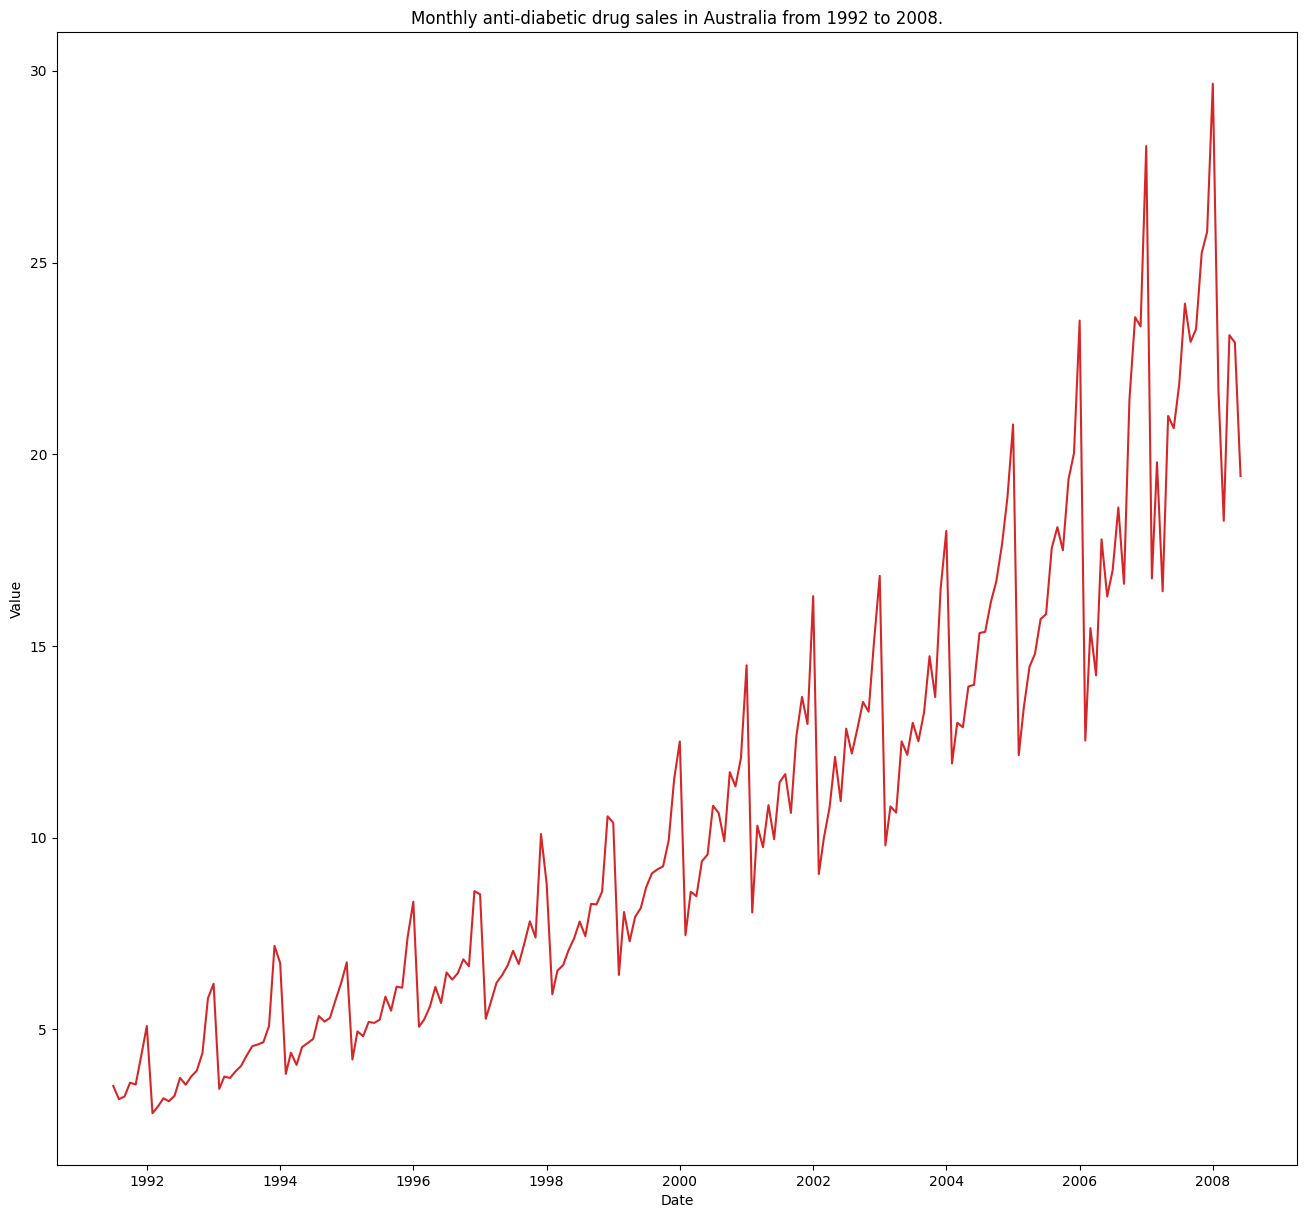

In [6]:
# Define function to plot the time series
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,15), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title="Monthly anti-diabetic drug sales in Australia from 1992 to 2008.")


There is a clear and increasing trend. There is also a strong seasonal pattern that increases in the size as the level of the series increases. The sudden drop at the start of each year is caused by a government subsidization scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts of this series would need to capture the seasonal pattern and the fatc tha the trend is changing slowly.

### Seasonal plot of a time series

In [7]:
#Reset the index
df.reset_index(inplace=True)

In [8]:
# Prepare the data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prepare Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

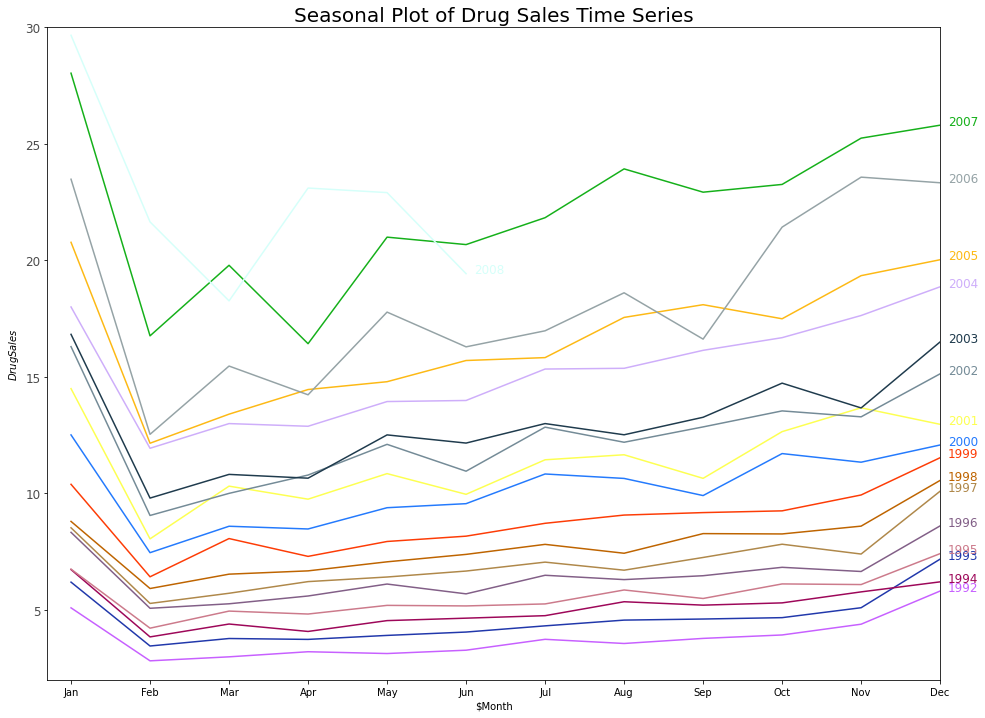

In [9]:
# Visualize seasonal variation in drug sales
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y,:].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel= '$Drug Sales$', xlabel='$Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

There is a large jump in sales in January each year. The graph also shows that there was an unusually small number of sales in March 2008 (most other years show and increase between February and March). The small number of sales in June 2008 is probably due to incomplete counting of sales at the time the date were collected.

However as year progress, the drug sales increase overall. We can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, we can do a month-wise boxplot to visualize the monthly distributions.

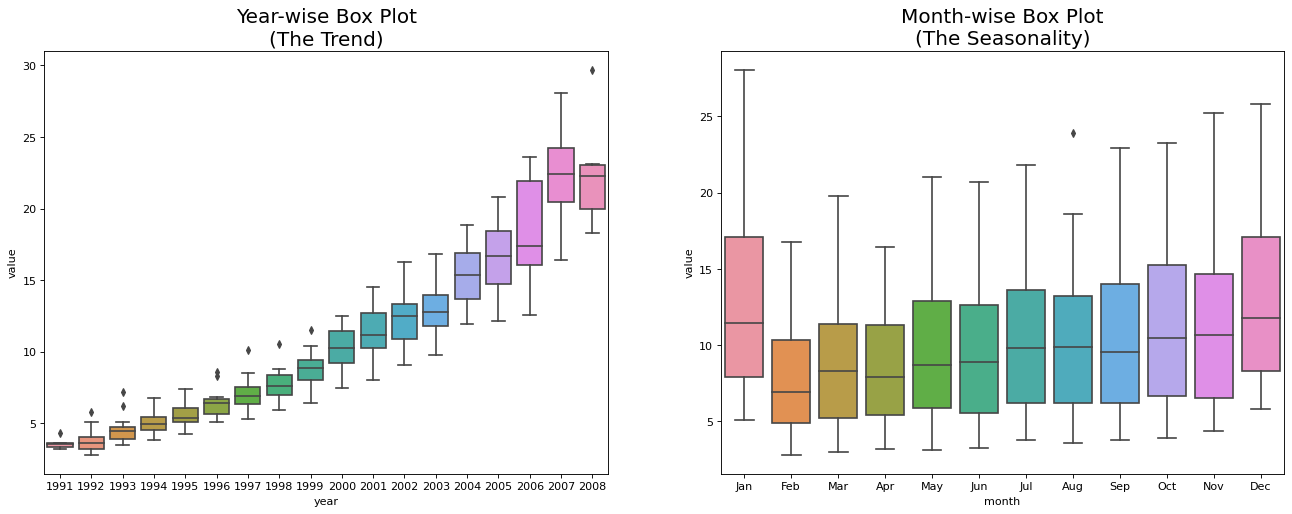

In [10]:
# Visulize the yearly and monthly drug sales using box plot
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set the title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and January clearly have higher drug sales, which can be attributed to the holiday discounts seasons.

Until now we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?

### Pattern in the series

Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

**Trend:**

A trend exists when there us a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to trend as "changing direction" when it might go from an increasing trend to decreasing trend. There is a trend in the antidiabetic drug sales data.

**Seasonality:**

A seasonal pattern ocuurs when a time-series is affected by seasonal factors such as the time of the year or day of the week. Seasonality is always of a fixed and known frequency. The monthly sales of the antidiabetic drugs above seasonality which is induced partly by the change in the cost of the drugs at the end of the calendar year.

**Residuals:**

When we remove the trend, seasonality, and other observable patterns from the data, white noise is left and this and this is termed as residuals.

A time series may be imagined as a combination of the trend, seasonality and the error/residual terms.

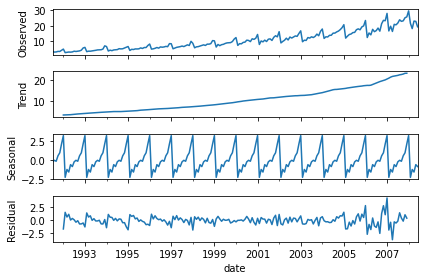

In [11]:
# Setting index back to date
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')

# Applying seasonal decompose
result = seasonal_decompose(df, model='additive')

# Plotting trend, seasonality and both trend and seasonality in drug sales data 
result.plot()
plt.show()

Another aspect to consider is the cyclic behavior. It happens when the rise and fall pattern in the series does not happen in fixed calendar based intervals. Care should be taken to not confuse 'cyclic effect with 'seasonal' effect.

So, How to differentiate between a 'cyclic' vs 'seasonal' pattern?

If the petterns are not of fixed calendar-based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive and Multiplicative Time-Series

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or mutliplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

$\text{Additive time series:}$

$\hspace{0.5cm}\text{=> Value = Base Level + Trend + Seasonality + Error}$

$\text{Multiplicative Time Series:}$

$\hspace{0.5cm}\text{=> Value = Base Level x Trend x Seasonality x Error}$

### Detrend a time series

Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the the time series steps as the predictor. For more complex trends, you may want to use quadratic terms $x^2$ in the model.

2. Subtract the trend component obtained from time series decomposition we saw earlier. 

3. Subtract he mean.

4. Apply a filter like Baxter-king filter(statsmodels.tsa.filters.bkfilter) or the Hordick-Prescott Filter(statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Let's implement the first two methods.

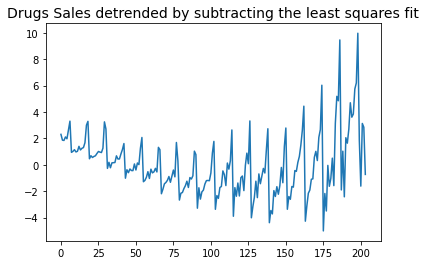

In [13]:
# Using the scipy: Subtract the line of best fit
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Drugs Sales detrended by subtracting the least squares fit', fontsize=14)
plt.show()

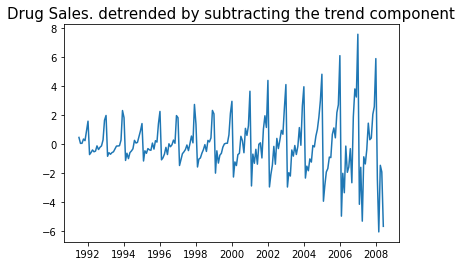

In [15]:
# Decompose the time-series first
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
# Detrending the time series by trend component
detrended = df.value.values - result_mul.trend 

# Plotting the detrended time series
plt.plot(detrended)
plt.title('Drug Sales. detrended by subtracting the trend component', fontsize=15)
plt.show()

### Deseasonlize a time series

There are multiple approaches to deseasonalize a time series as well. Below are a few:

1. Taking a moving average with length as the seasonal window. This will smoothen the series in process.

2. Seasonal difference the series(subtract the value of previous season from the current value)

3. Divide the series by the seasonal index obtained from STL decomposition.

If dividing by seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

In [18]:
# Time series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize the time series
deseasonalized = df.value.values / result_mul.seasonal

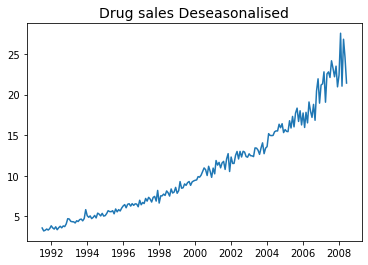

In [19]:
# Visualize deseasonalise time series
plt.plot(deseasonalized)
plt.title('Drug sales Deseasonalised', fontsize=14)
plt.show()

### Autocorrelation and Partial Autocorrelation Functions

Autocorrelation is simply the correlations of a series with its own lags. If a series is significantly autocorrelated, that mean, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys the similar information but it conveys the pure correlations of a series and its lag, excluding the correlation from the intermediate lags.

Two 2D plots showing the lag value and along the x-axis and the correlation (for both acf and pacf) on the y-axis between -1 and 1.

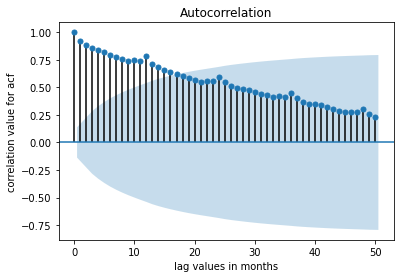

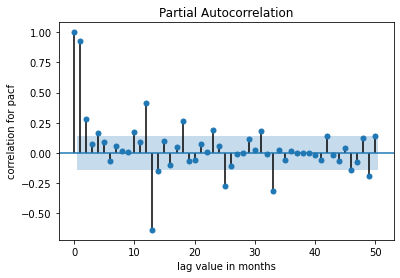

In [21]:
# Draw ACF Plot
acf_50 = plot_acf(df['value'], lags=50)
plt.xlabel('lag values in months')
plt.ylabel('correlation value for acf')
acf_50.show()

# Draw PACF Plot
pacf_50 = plot_pacf(df['value'], lags=50)
plt.xlabel('lag value in months')
plt.ylabel('correlation for pacf')
pacf_50.show()

Confidence intervals are drawn as `blue part`. By default, this is set to $95%$ confidence interval, sugegsting that correlation outside of this cone are very likely a correaltion.

**Intuition of ACF plot**

As per the above ACF plot, we have a good correlation up to 14 to 15 lag, this is the lag after which the plot cuts the upper confidence interval.

**Intuition**

If we see the PACF plot there are many instances where the correlation is the above upper confidence band as PACF calculates correlations of lags of time series with residuals and our series itself is linear combination of residuals and its lagged values. Hence we can get a good correlation for near as well as past lags.

<font color='blue'>**Discussion1:** So how to compute partic=al autocorrelation? Here we will disucss the mathematics behind it.</font>

### Lag Plots

A Lag plot is a scatter plot of a time series using a lag of itself. It is normally used to check for autocorrelation. If there is any pattern in the exisiting series like the one you see below , the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In the below is snapshot area time series, the plots get more and more scattered as the n_lag increases.

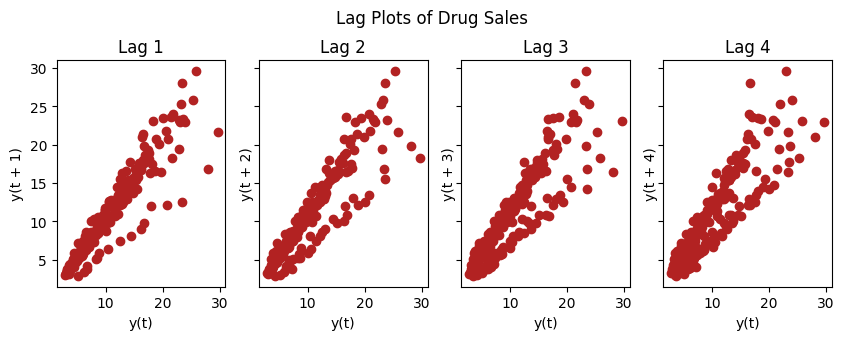

In [22]:
# Visualize lag plots

fig, axes = plt.subplots(1,4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' +str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)
plt.show()

### How to smoothen a time series

<font color='blue'>**Discussion2:** Firstly, let us discuss why do we smoothen our time series?</font>

So how to smoothen a series? Let's discuss the following methods:

1. Take a moving average
2. Do a LOESS smoothing (Localized Reggression)
3. Do a LOWESS smoothing(Locally WEIGHTED Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size to the seasonal duration(ex: 12 for a month-wsie series), will effective nullify the seasonal effect.

LOESS, short for 'Localized regression' fits mutliple regression in the local neighbourhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to a fit a regression model.

Text(0.5, 0.95, 'How to Smoothen a Time Series')

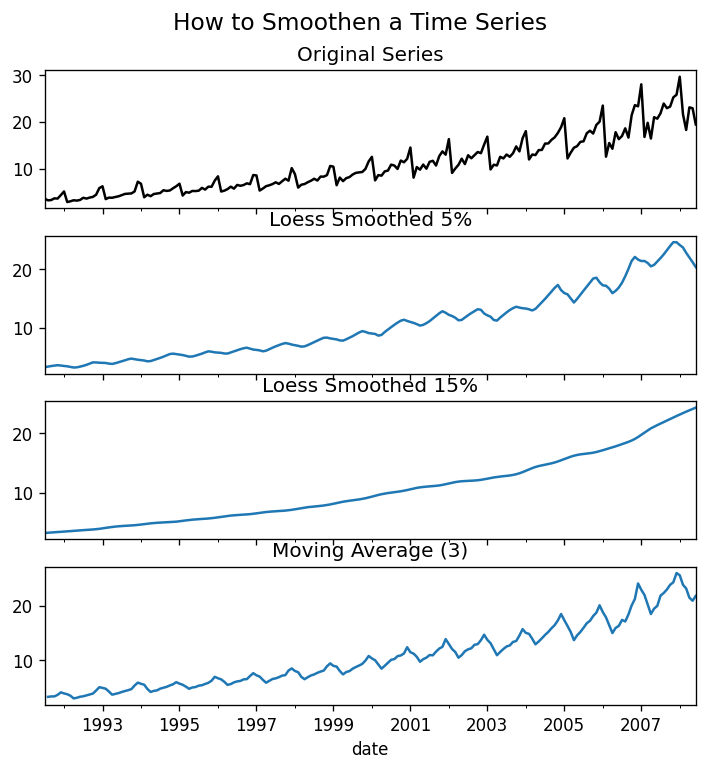

In [25]:
# 1. Moving Average
df_ma = df.value.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Visualize Moving average and Loess smoothing
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)

### Granger Causality test to know if One Time Series helps Forecast Another

Granger causality test is used to determine if one time series will be useful to forecast another.

**How does Granger causality test work?**

It is based on the idea that if X caused Y, then the forecast of Y based on previous values of Y and the previous values of X should outperform the forecast of Y based on previous values of Y alone.

So, understand that Granger causality should not be used ot test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only.

It is nicely implemented in the statsmodel packages.

It accepts a 2D array with 2 columns as the main argument. The value are in the first column and the predictor (X) is in the second column.

The Null hypothesis is: the series in the second column, does Granger cause the series in the first. If the P-Values are less than a significant level (0.05) then you reject the null hypothesis and conclude that the lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test. 

In [26]:
# Perform Granger Causality test
df.reset_index(inplace=True)
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=55.6014 , p=0.0000  , df=1
likelihood ratio test: chi2=49.1426 , p=0.0000  , df=1
parameter F test:         F=54.7797 , p=0.0000  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=333.6567, p=0.0000  , df=2
likelihood ratio test: chi2=196.9956, p=0.0000  , df=2
parameter F test:         F=162.6989, p=0.0000  , df_denom=197, df_num=2


In the above case, the P-Values are Zero for all tests. So the `month` indeed can be used to forecast the Drug Sales

**Note** Next step is to begin forecasting